In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import torch

In [2]:
directory = 'C:\datasets\img_align_celeba\img_align_celeba'

In [3]:
tag = pd.read_csv('C:/datasets/list_attr_celeba.csv')

In [4]:
col = ['image_id', 'Male', 'Mustache', 'Bald', 'Smiling', 'Young']
tag = tag[col]
tag = tag.replace(-1, 0)
col = col[1:]
tag

,image_id,Male,Mustache,Bald,Smiling,Young
0,000001.jpg,0,0,0,1,1
1,000002.jpg,0,0,0,1,1
2,000003.jpg,1,0,0,0,1
3,000004.jpg,0,0,0,0,1
4,000005.jpg,0,0,0,0,1
...,...,...,...,...,...,...
202594,202595.jpg,0,0,0,0,1
202595,202596.jpg,1,0,0,1,1
202596,202597.jpg,1,0,0,1,1
202597,202598.jpg,0,0,0,1,1


In [5]:
train = tag.sample(frac = .8, random_state=42)
test = tag.drop(train.index)
train

,image_id,Male,Mustache,Bald,Smiling,Young
93241,093242.jpg,1,0,0,0,1
121413,121414.jpg,0,0,0,0,1
10624,010625.jpg,1,0,0,0,1
82523,082524.jpg,0,0,0,1,1
73192,073193.jpg,0,0,0,1,0
...,...,...,...,...,...,...
36890,036891.jpg,1,0,0,0,1
1992,001993.jpg,0,0,0,0,1
47852,047853.jpg,0,0,0,1,1
79821,079822.jpg,0,0,0,1,1


In [6]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [7]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory = directory,
x_col="image_id",
y_col=col,
subset="training",
batch_size=16,
seed=42,
shuffle=True,
    class_mode='raw',
target_size=(256,256))

valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory=directory,
x_col="image_id",
y_col=col,
subset="validation",
batch_size=16,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(256,256))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory=directory,
x_col="image_id",
y_col=col,
batch_size=16,
seed=42,
shuffle=False,
class_mode='raw',
target_size=(256,256))

Found 121560 validated image filenames.
Found 40519 validated image filenames.
Found 40520 validated image filenames.


In [8]:
class MLP(tf.keras.layers.Layer):
    def __init__(self, in_channel:int, hidden_channel:int, dropout:float = 0.):
        super(MLP, self).__init__()
        self.in_channel = in_channel
        self.hidden_channel = hidden_channel
        self.dropout = dropout
        
        self.fc1 = tf.keras.layers.Dense(self.hidden_channel, activation = tf.keras.activations.gelu, kernel_initializer = tf.keras.initializers.lecun_normal())
        self.d = tf.keras.layers.Dropout(self.dropout)
        self.fc2 = tf.keras.layers.Dense(self.in_channel, kernel_initializer = tf.keras.initializers.lecun_normal())
        
    def call(self, X):
        X = self.fc1(X)
        X = self.d(X)
        X = self.fc2(X)
        return X
        
class MLP_block(tf.keras.layers.Layer):
    def __init__(self, n_patches:int, n_channels:int, mlp_ratio:int):
        super(MLP_block, self).__init__()
        self.n_patches = n_patches
        self.n_channels = n_channels
        self.mlp_ratio = mlp_ratio
        
        self.MLP1 = MLP(self.n_channels, self.n_channels*self.mlp_ratio)
        self.MLP2 = MLP(self.n_patches, self.n_patches*self.mlp_ratio)
        self.ln1 = tf.keras.layers.LayerNormalization()
        self.ln2 = tf.keras.layers.LayerNormalization()
        self.T = tf.keras.layers.Permute((2,1))
        
    def call(self, X):
        #channel
        y = self.ln1(X)
        y = self.MLP1(y)
        X = y + X
        #token(Spatial)
        y = self.T(X)
        y = self.ln2(y)
        y = self.MLP2(y)
        y = self.T(y)
        y = y + X
        return y
    

class LVT(tf.keras.models.Model):
    def __init__(self, n_channels:int, image_size:int, patch_size:int, n_blocks:int, mlp_ratio:int, batch_size:int, n_labels:int, mode:str = 'softmax'):
        super(LVT, self).__init__()
        self.n_channels = n_channels
        self.image_size = image_size
        self.patch_size = patch_size
        if (self.image_size % self.patch_size) != 0:
            raise ValueError('size error')
        self.n_patches = int((tf.square(self.image_size) / tf.square(self.patch_size)).numpy())
        self.n_blocks = n_blocks
        self.mlp_ratio = mlp_ratio
        self.batch_size = batch_size
        
        self.n_labels = n_labels
        if mode not in ['sigmoid','softmax']:
            raise ValueError('mode must be sigmoid or softmax')
        else:
            self.mode = mode
        
        self.patchConv = tf.keras.layers.Conv2D(self.n_channels, (self.patch_size, self.patch_size), strides = (self.patch_size, self.patch_size))
        self.CLS = tf.Variable(tf.random.truncated_normal([1, self.n_channels], stddev=.02))
        self.PE = tf.Variable(tf.random.truncated_normal([self.n_patches + 1, self.n_channels], stddev=.02))
        self.MLP_Blocks = [MLP_block(self.n_patches + 1, self.n_channels, self.mlp_ratio) for x in range(self.n_blocks)] # n_patchs + cls token
        self.ln = tf.keras.layers.LayerNormalization()
        self.head = tf.keras.layers.Dense(self.n_labels if self.n_labels > 2 else 1, activation = mode, kernel_initializer = tf.keras.initializers.glorot_normal(seed = 42))
        
    def call(self, X):
        X = self.patchConv(X)
        X = tf.reshape(X, [-1, self.n_patches, self.n_channels])
        CLS = tf.broadcast_to(self.CLS, [tf.shape(X)[0], 1, self.n_channels])
        X = tf.concat([CLS, X], 1)
        PE = tf.broadcast_to(self.PE, [tf.shape(X)[0], self.n_patches + 1, self.n_channels])
        X = X + PE
        
        for MLP in self.MLP_Blocks:
            X = MLP(X)
        X = self.ln(X)
        X = X[:,:,0]
        X = self.head(X) 
        return X

In [9]:
lvt = LVT(192, 256, 16, 12, 4, 16, len(col), mode = 'sigmoid')
opt = tf.keras.optimizers.Adam(.00005)
lvt.compile(optimizer=opt, loss=tfa.losses.focal_loss.sigmoid_focal_crossentropy, metrics='acc')

In [10]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
lvt.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

C:\Users\soymi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
7597/7597 [==============================] - 737s 96ms/step - loss: 0.1207 - acc: 0.7399 - val_loss: 0.1042 - val_acc: 0.7696
Epoch 2/10
7597/7597 [==============================] - 712s 94ms/step - loss: 0.0931 - acc: 0.7986 - val_loss: 0.0915 - val_acc: 0.7836
Epoch 3/10
7597/7597 [==============================] - 708s 93ms/step - loss: 0.0824 - acc: 0.8150 - val_loss: 0.0874 - val_acc: 0.8057
Epoch 4/10
7597/7597 [==============================] - 707s 93ms/step - loss: 0.0726 - acc: 0.8282 - val_loss: 0.0887 - val_acc: 0.8292
Epoch 5/10
7597/7597 [==============================] - 707s 93ms/step - loss: 0.0608 - acc: 0.8384 - val_loss: 0.0952 - val_acc: 0.8255
Epoch 6/10
7597/7597 [==============================] - 707s 93ms/step - loss: 0.0475 - acc: 0.8416 - val_loss: 0.1106 - val_acc: 0.7964
Epoch 7/10
7597/7597 [==============================] - 709s 93ms/step - loss: 0.0339 - acc: 0.8349 - val_loss: 0.1486 - val_acc: 0.8047
Epoch 8/10
7597/7597 [===================

In [11]:
lvt.PE

<tf.Variable 'Variable:0' shape=(257, 192) dtype=float32, numpy=
array([[ 0.01141832,  0.02318444,  0.00657504, ..., -0.01336386,
        -0.00922897, -0.01132952],
       [ 0.04122784, -0.02377934, -0.02151338, ..., -0.01532631,
         0.0162439 ,  0.03773548],
       [ 0.00465092, -0.04881857,  0.00383789, ..., -0.03465632,
        -0.00820508, -0.03772423],
       ...,
       [-0.0216959 , -0.00335718,  0.01963238, ...,  0.04197867,
         0.04883619,  0.01156144],
       [ 0.01623117,  0.01613571, -0.01536046, ...,  0.01558637,
        -0.0013143 ,  0.02926772],
       [-0.05440116,  0.00789918,  0.00166385, ..., -0.02447374,
         0.0576378 , -0.02091218]], dtype=float32)>

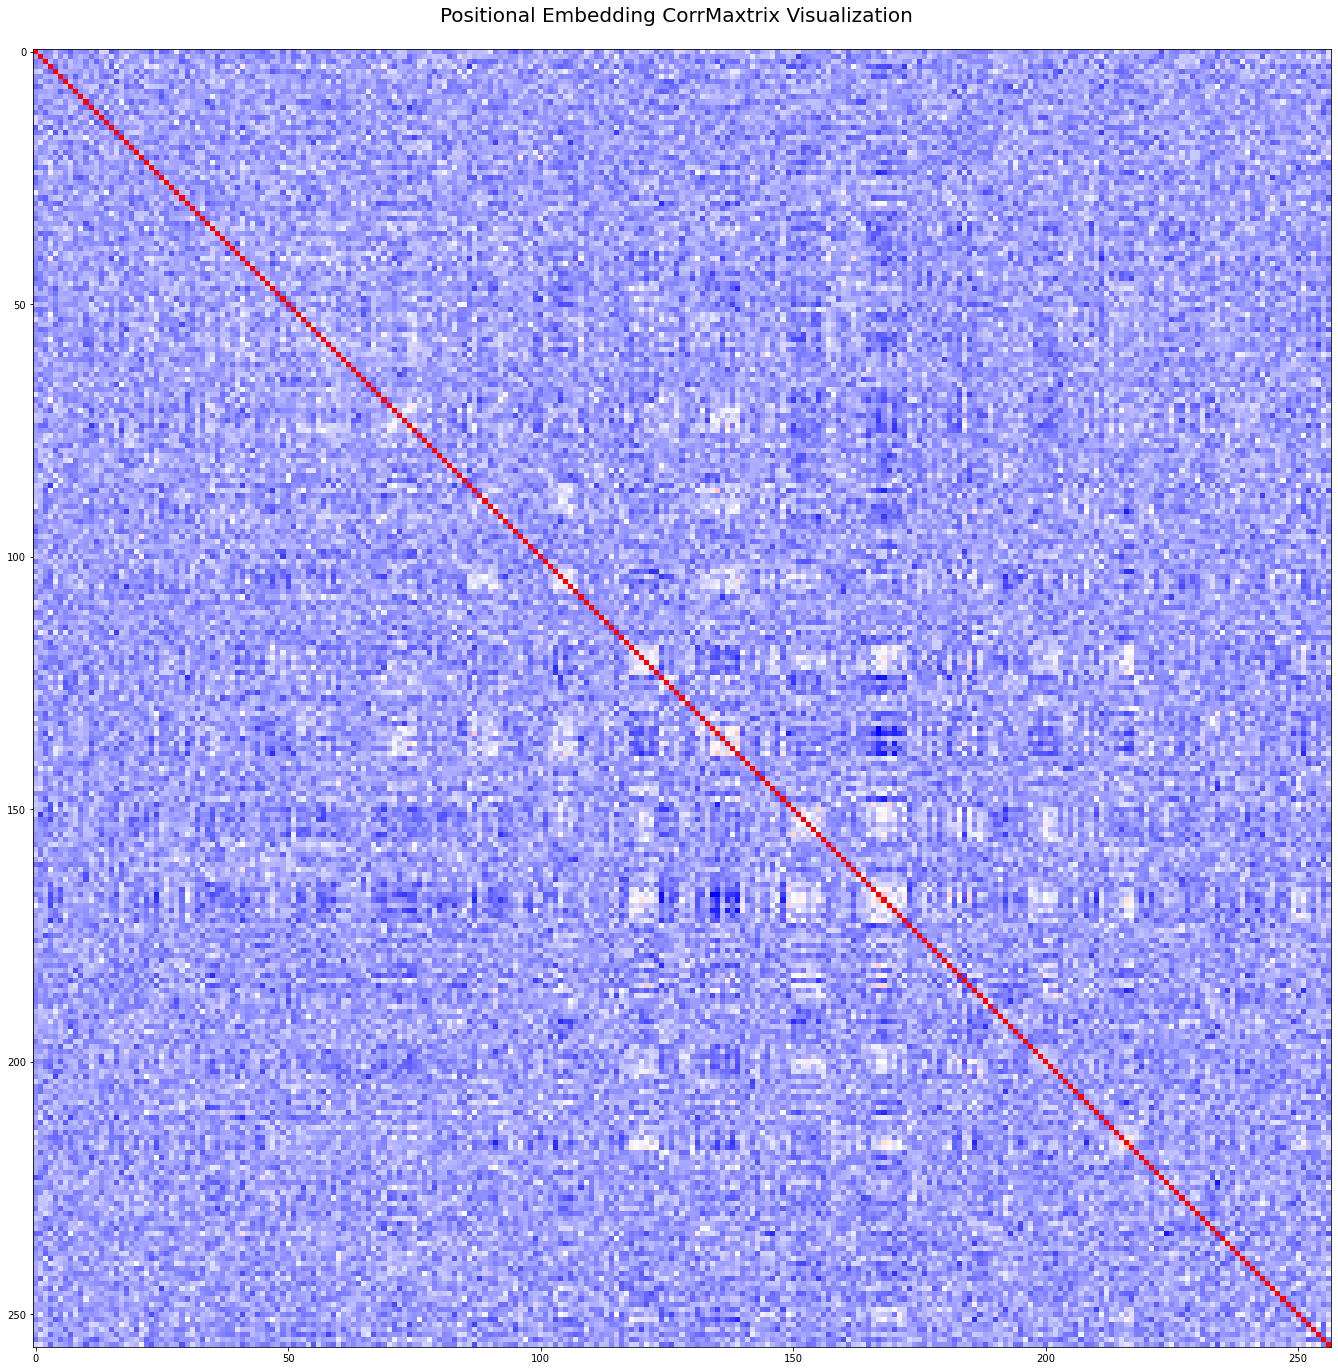

In [14]:
PE = np.corrcoef(lvt.PE.numpy()) 
fig, ax = plt.subplots(figsize = (20,20))
ax.imshow(PE, cmap = plt.cm.bwr)
plt.suptitle('Positional Embedding CorrMaxtrix Visualization', fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

<function numpy.corrcoef(x, y=None, rowvar=True, bias=<no value>, ddof=<no value>)>